# Introduction

This notebook is dedicated to the study, analysis, and implementation of the research paper titled **"Rich feature hierarchies for accurate object detection and semantic segmentation"**. Authored by Ross B. Girshick, Jeff Donahue, Trevor Darrell, and Jitendra Malik, this paper, published in 2014, introduced a groundbreaking approach to **object detection** and **semantic segmentation** in computer vision.

In this notebook, we will focus on the object detection part of the paper.


<div align="center">
<img src="./resources/RCNN.jpg" width="1000"/>
</div>


The Region-based Convolutional Neural Network introduced in the 2014 paper by Ross B. Girshick et al. Here is a description of the original R-CNN architecture:

<ul>
    <li><strong>Region Proposal Generation</strong>:
        <ul>
            <li>The process starts with generating region proposals using a method called <strong>Selective Search</strong>. Selective Search identifies regions in an image that are likely to contain objects. These regions serve as candidate bounding boxes.</li>
        </ul>
    </li>
    <br />
    <li><strong>CNN Feature Extraction</strong>:
        <ul>
            <li>Each region proposal is subsequently resized to a uniform size and processed through a pre-trained Convolutional Neural Network (CNN). This CNN extracts a feature vector for each region, a pivotal step that transforms variable-sized regions into a standardized, fixed-length feature vector. In line with the original paper, we will employ the <strong>AlexNet</strong> CNN architecture for this task. Additionally, the authors pretrained the AlexNet model on the ImageNet dataset, a step we will omit. Instead, we will directly utilize the pre-trained AlexNet on ImageNet provided by PyTorch.</li>
        </ul>
    </li>
    <br />
    <li><strong>Classification</strong>:
        <ul>
            <li>The feature vectors extracted are utilized to train a classification model. In the original R-CNN approach, the authors utilized the Support Vector Machine (SVM) classifier for this task. The SVM distinguishes between object and non-object regions, predicting the respective class labels. However, for the purposes of this notebook, a different approach is taken. A simple dense linear layer followed by a softmax activation function is employed. This choice aligns with modern object detection architectures, which often use neural network-based classifiers in an end-to-end training process.</li>
        </ul>
    </li>
    <br />
    <li><strong>Bounding Box Refinement</strong>:
        <ul>
            <li>Additionally, bounding box regression is executed to fine-tune the coordinates of the suggested bounding boxes, thereby enhancing localization accuracy. However, in this notebook, we will abstain from refining the bounding boxes. The rationale behind this decision is that we will later delve in another project into the Faster R-CNN architecture, which employs an optimized and sophisticated approach for bounding box refinement.</li>
        </ul>
    </li>
    <br />
    <li><strong>Non-Maximum Suppression (NMS)</strong>:
        <ul>
            <li>After obtaining the final set of region proposals, a post-processing step called Non-Maximum Suppression is applied. It helps remove redundant and overlapping bounding boxes, keeping only the most confident detections. I also added an Intersection over Minimum criterion to delete some noisy detections.</li>
        </ul>
    </li>
    <br />
</ul>

Note : The original paper conducted two training phases. The initial training utilized a dataset generated with an IoU threshold of 0.5 between box proposals and ground truths. The second training employed a threshold of 0.3. This approach contributed to improved performance. In this notebook, I conducted a single training phase in which I opted for custom thresholds: 0.7 for distinguishing objects (IoU > 0.7 implies object) and 0.3 for distinguishing background (IoU < 0.3 implies background). This decision was based on my observation of the generated dataset and the recognition that the thresholds used by the authors were not suitable for my relatively small dataset.

I acknowledge that the thresholds I selected are somewhat arbitrary and are not grounded in empirical evidence. However, this is not a problem since my objective is not to attain the utmost accuracy (if that were my primary goal, I would have opted for a different model altogether), but rather to satisfy my curiosity and gain a better understanding of the architecture and its functioning.

In [1]:
# Dependencies
import os
import cv2
import pickle
import shutil
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import random
from google.colab import drive

random.seed(42)
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# RCNN CONFIGURATIONS
CNN_INPUT_SIZE = 227
MAX_PROPOSALS = 500
PADDING = 16

# TRAINING CONFIGURATIONS
EPOCHS = 2
BATCH_SIZE = 128
MOMENTUM = 0.9
LR = 0.001

# FULL DATA CONFIGURATIONS
IMAGES_PATH = os.path.join("data", "JPEGImages")
ANNOTATIONS_PATH = os.path.join("data", "Annotations")
TRAIN_TEST_RATIO = 0.7
N_CLASSES = 21

# TRAIN DATA PATHS
TRAIN_PATH = os.path.join("data", "train")
TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH, "images")
TRAIN_ANNOTATIONS_PATH = os.path.join(TRAIN_PATH, "annotations")

# FOREGROUND_DATAPATH = os.path.join(TRAIN_PATH, "foreground_dataset.pkl")
# BACKGROUND_DATAPATH = os.path.join(TRAIN_PATH, "background_dataset.pkl")
FOREGROUND_DATAPATH = "./drive/MyDrive/datasets/foreground_dataset.pkl"
BACKGROUND_DATAPATH = "./drive/MyDrive/datasets/background_dataset.pkl"

# TEST DATA PATHS
TEST_PATH = os.path.join("data", "test")
TEST_IMAGES_PATH = os.path.join(TEST_PATH, "images")
TEST_ANNOTATIONS_PATH = os.path.join(TEST_PATH, "annotations")

# DATASET CONFIGURATIONS
LABEL_NAMES = [
    "background", "aeroplane", "bicycle", "bird",
    "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
    ]

# DEVICE
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# download and extract voc 2008 dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
!tar -xf VOCtrainval_14-Jul-2008.tar
shutil.move("./VOCdevkit/VOC2008", "./VOC2008")
os.rename("./VOC2008/", "./data")

--2023-09-13 19:13:13--  http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577034240 (550M) [application/x-tar]
Saving to: ‘VOCtrainval_14-Jul-2008.tar’

VOCtrainval_14-Jul- 100%[===================>] 550.30M   238MB/s    in 2.3s    

2023-09-13 19:13:16 (238 MB/s) - ‘VOCtrainval_14-Jul-2008.tar’ saved [577034240/577034240]



# Dataset

In [4]:
# Create the train and test folders if they don't exist
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(TEST_ANNOTATIONS_PATH, exist_ok=True)

# Split the images and annotations into train and test sets
IMAGE_NAMES = sorted(os.listdir(IMAGES_PATH))
TRAIN_IMAGE_NAMES = IMAGE_NAMES[:int(len(IMAGE_NAMES)*TRAIN_TEST_RATIO)]
TEST_IMAGE_NAMES = IMAGE_NAMES[int(len(IMAGE_NAMES)*TRAIN_TEST_RATIO):]

# Copy the images to the corresponding train and test folders
for image_name in TRAIN_IMAGE_NAMES:
    image_path = os.path.join(IMAGES_PATH, image_name)
    annot_path = os.path.join(ANNOTATIONS_PATH, image_name.split(".")[0] +".xml")
    shutil.copy(image_path, TRAIN_IMAGES_PATH)
    shutil.copy(annot_path, TRAIN_ANNOTATIONS_PATH)

for image_name in TEST_IMAGE_NAMES:
    image_path = os.path.join(IMAGES_PATH, image_name)
    annot_path = os.path.join(ANNOTATIONS_PATH, image_name.split(".")[0] +".xml")
    shutil.copy(image_path, TEST_IMAGES_PATH)
    shutil.copy(annot_path, TEST_ANNOTATIONS_PATH)

In [5]:
def load_image_annotations(image_name):
    """
    Load annotations for a given image.

    Parameters:
        image_name (str): The name of the image file.

    Returns:
        dict: A dictionary containing image information and annotations.
              The dictionary has the following keys:
              - 'width' (int): The width of the image.
              - 'height' (int): The height of the image.
              - 'area' (int): The area of the image (width * height).
              - 'boxes' (list of tuples): List of bounding boxes in the format (xmin, ymin, xmax, ymax).
              - 'labels' (list of int): List of labels corresponding to each bounding box.

    Raises:
        FileNotFoundError: If the annotations file is not found.

    Example:
        >>> image_info = load_image_annotations('example.jpg')
    """
    # Get annotations file path
    image_name_without_extension = os.path.splitext(image_name)[0]
    annot_file_path = os.path.join(ANNOTATIONS_PATH, image_name_without_extension + '.xml')

    # Parse XML file
    tree = ET.parse(annot_file_path)
    root = tree.getroot()

    # Extract image dimensions
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)

    # Initialize lists to store bounding boxes and labels
    bounding_boxes = []
    labels = []

    for obj in root.findall(".//object"):
        # Extract object name (label)
        label_name = obj.find('name').text

        # Extract bounding box coordinates
        xmin = float(obj.find('.//bndbox/xmin').text)
        ymin = float(obj.find('.//bndbox/ymin').text)
        xmax = float(obj.find('.//bndbox/xmax').text)
        ymax = float(obj.find('.//bndbox/ymax').text)

        bounding_boxes.append((xmin, ymin, xmax, ymax))
        labels.append(LABEL_NAMES.index(label_name))

    return {
        "width": width,
        "height": height,
        "area": width * height,
        "boxes": bounding_boxes,
        "labels": labels,
    }

# Demo : Load image annotations
image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
load_image_annotations(image_name)

{'width': 334,
 'height': 500,
 'area': 167000,
 'boxes': [(113.4072, 97.9042, 281.6707, 500.0)],
 'labels': [15]}

In [6]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
        box1 (tuple): Tuple (x1, y1, x2, y2) representing the first bounding box.
        box2 (tuple): Tuple (x1, y1, x2, y2) representing the second bounding box.

    Returns:
        float: Intersection over Union between the two bounding boxes.
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Sanity Check
    assert x1_1 < x2_1 and y1_1 < y2_1, "Box 1 is not valid."
    assert x1_2 < x2_2 and y1_2 < y2_2, "Box 2 is not valid."

    # Calculate the intersection area
    intersection_x1 = max(x1_1, x1_2)
    intersection_y1 = max(y1_1, y1_2)
    intersection_x2 = min(x2_1, x2_2)
    intersection_y2 = min(y2_1, y2_2)

    intersection_area = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)

    # Calculate the area of each bounding box
    area_box1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area_box2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

    # Calculate the Union area
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

# Demo : Calculate IoU
box1 = [10, 10, 50, 50]
box2 = [20, 20, 60, 60]

calculate_iou(box1, box2)

0.40024989587671805

In [7]:
def calculate_iom(box1, box2):
    """
    Calculate the Intersection over Minimum (IoM) of two bounding boxes.

    Parameters:
    - box1: Tuple (x1, y1, x2, y2) representing the first bounding box.
    - box2: Tuple (x1, y1, x2, y2) representing the second bounding box.

    Returns:
    - IoM: Intersection over Minimum between the two bounding boxes as a float.
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Sanity Check
    assert x1_1 < x2_1 and y1_1 < y2_1, "Box 1 is not valid."
    assert x1_2 < x2_2 and y1_2 < y2_2, "Box 2 is not valid."

    # Calculate the intersection area
    intersection_x1 = max(x1_1, x1_2)
    intersection_y1 = max(y1_1, y1_2)
    intersection_x2 = min(x2_1, x2_2)
    intersection_y2 = min(y2_1, y2_2)

    intersection_area = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)

    # Calculate the area of each bounding box
    area_box1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area_box2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

    # Calculate the minimum area
    min_area = min(area_box1, area_box2)

    # Calculate IoM
    iom = intersection_area / min_area

    return iom

# Demo : Calculate IoM
box1 = [10, 10, 50, 50]
box2 = [20, 20, 60, 60]

calculate_iom(box1, box2)

0.5716835217132659

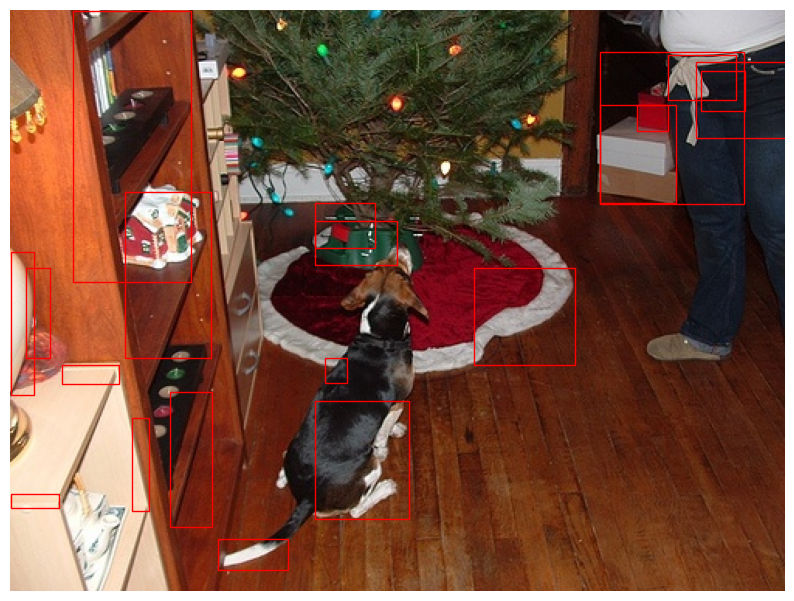

In [8]:
import cv2
import os
import random
import matplotlib.pyplot as plt

def generate_region_proposals(image, num_regions, fast_mode=True):
    """
    Generate region proposals using Selective Search.

    Parameters:
        image (numpy.ndarray): The input image.
        num_regions (int): The number of region proposals to generate.
        fast_mode (bool, optional): Whether to use fast mode for selective search.
                                    Defaults to True.

    Returns:
        list of tuples: A list of region proposals in the format (x1, y1, x2, y2).

    Example:
        >>> image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
        >>> image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
        >>> image = cv2.imread(image_path)
        >>> image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        >>> regions = generate_region_proposals(image, 20, False)
    """
    # Create a selective search object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # Set the input image for selective search
    ss.setBaseImage(image)

    if fast_mode:
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    # Perform selective search
    regions = ss.process()
    regions = regions[:num_regions]
    regions = [(x, y, x + w, y + h) for x, y, w, h in regions]
    return regions

# Demo : Generate region proposals
image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
regions = generate_region_proposals(image, 20, False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for xmin, ymin, xmax, ymax in regions:
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.axis('off')
plt.show()


In [9]:
def generate_rcnn_dataset(
        data_path,
        iou_threshold = 0.7,
        background_iou_threshold = 0.3,
        sample_ratio = 1/4
        ):
    """
    Generate a dataset for Region-based Convolutional Neural Network (R-CNN) training.

    This function combines foreground and background data for R-CNN training.

    Parameters:
        data_path (str): Path to the data directory.
        iou_threshold (float, optional): IoU threshold for foreground objects. Defaults to 0.7.
        background_iou_threshold (float, optional): IoU threshold for background. Defaults to 0.3.
        sample_ratio (float, optional): Sample ratio of background to objects. Defaults to 1/4.

    Returns:
        tuple: A tuple containing two dictionaries:
            - foreground_data (dict): Data for foreground objects with keys:
                - 'image_names' (list of str): Image names.
                - 'roi_boxes' (list of tuples): Region of interest bounding boxes.
                - 'annot_boxes' (list of tuples): Annotated bounding boxes.
                - 'labels' (list of int): Labels.
            - background_data (dict): Data for background with keys:
                - 'image_names' (list of str): Image names.
                - 'roi_boxes' (list of tuples): Region of interest bounding boxes.
                - 'annot_boxes' (list of tuples): Annotated bounding boxes.
                - 'labels' (list of int): Labels.

    Example:
        >>> foreground_data, background_data = generate_rcnn_dataset('data/', iou_threshold=0.7)
    """

    # Get image names
    images_path = os.path.join(data_path, "images")
    image_names = sorted(os.listdir(images_path))

    nb_objects = 0
    nb_background = 0

    # Intiliaze lists to store images, bounding boxes and labels
    foreground_data = {
        "image_names": [],
        "roi_boxes": [],
        "annot_boxes": [],
        "labels": []
    }

    background_data = {
        "image_names": [],
        "roi_boxes": [],
        "annot_boxes": [],
        "labels": []
    }

    for i, image_name in enumerate(image_names):
        if i % 100 == 99:
            print(f"Processing image {i+1}/{len(image_names)}")

        # Load ground truth annotations
        gt_annots = load_image_annotations(image_name)
        gt_bboxes = gt_annots["boxes"]
        gt_labels = gt_annots["labels"]

        # Generate region proposals
        image = cv2.imread(os.path.join(images_path, image_name))
        roi_bboxes = generate_region_proposals(image, MAX_PROPOSALS)

        for bbox in roi_bboxes:
            # Compute IoU between the region proposal
            # and all ground truth bounding boxes
            iou_max = 0

            for gt_label, gt_bbox in zip(gt_labels, gt_bboxes):
                iou = calculate_iou(bbox, gt_bbox)
                iou_max = max(iou_max, iou)
                if iou > iou_threshold:
                    foreground_data["image_names"].append(image_name)
                    foreground_data["roi_boxes"].append(bbox)
                    foreground_data["annot_boxes"].append(gt_bbox)
                    foreground_data["labels"].append(gt_label)

                    # Increment number of objects
                    nb_objects += 1

            ratio_is_respected = (nb_background <= nb_objects * sample_ratio)
            is_background = (iou_max < background_iou_threshold)
            if is_background and ratio_is_respected:
                background_data["image_names"].append(image_name)
                background_data["roi_boxes"].append(bbox)
                background_data["annot_boxes"].append(bbox)
                background_data["labels"].append(0)

                # Increment number of objects
                nb_background += 1

    return foreground_data, background_data

In [10]:
# If the dataset has already been generated, load it
if os.path.exists(FOREGROUND_DATAPATH) and os.path.exists(BACKGROUND_DATAPATH):
    foreground_data = pickle.load(open(FOREGROUND_DATAPATH, "rb"))
    background_data = pickle.load(open(BACKGROUND_DATAPATH, "rb"))

# If not, generate and save it to disk
else:
    foreground_data, background_data = generate_rcnn_dataset(TRAIN_PATH)
    with open(FOREGROUND_DATAPATH, "wb") as f:
        pickle.dump(foreground_data, f)
    with open(BACKGROUND_DATAPATH, "wb") as f:
        pickle.dump(background_data, f)

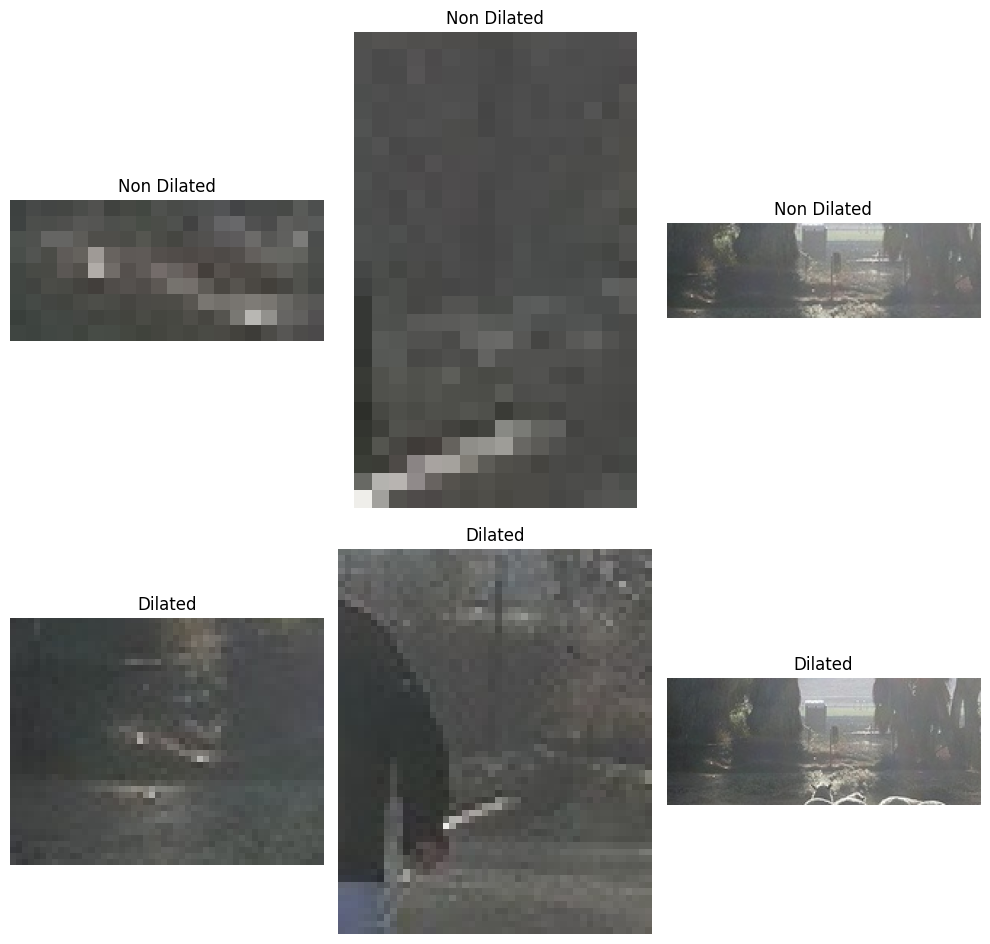

In [11]:
def dilate(image, bbox, padding=PADDING):
    """
    Dilate a bounding box in an image.

    This function dilates a bounding box by adding padding to it while ensuring that the
    resulting bounding box remains within the bounds of the image. If the padded region
    goes beyond the image bounds, it is filled with the mean value of the image.

    Parameters:
        image (numpy.ndarray): The input image.
        bbox (tuple): The bounding box in the format (x1, y1, x2, y2).
        padding (int, optional): The amount of padding to add to the bounding box. Defaults to 0.

    Returns:
        tuple: A tuple containing two elements:
            - roi (numpy.ndarray): The region of interest after dilation.
            - dilated_bbox (tuple): The dilated bounding box in the format (x1, y1, x2, y2).
    """
    # Extract coordinates from bounding box
    x1, y1, x2, y2 = bbox

    # Add padding to the bounding box
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(image.shape[1], x2 + padding)
    y2 = min(image.shape[0], y2 + padding)

    # Crop the padded bounding box to ensure it's within image bounds
    dilated_bbox = [x1, y1, x2, y2]

    # Get the region of interest from the image
    roi = image[y1:y2, x1:x2]

    # If the padded region goes beyond image bounds, fill with mean value
    if roi.shape[0] < (y2 - y1):
        pad_top = y1
        pad_bottom = image.shape[0] - y2
        roi = np.pad(roi, [(pad_top, pad_bottom), (0, 0), (0, 0)], mode='constant', constant_values=np.mean(image))

    if roi.shape[1] < (x2 - x1):
        pad_left = x1
        pad_right = image.shape[1] - x2
        roi = np.pad(roi, [(0, 0), (pad_left, pad_right), (0, 0)], mode='constant', constant_values=np.mean(image))

    return roi, dilated_bbox


# Demo : Dilate bounding box
image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


rois = []
dilated_rois = []
roi_bboxes = generate_region_proposals(image, MAX_PROPOSALS)

for i in range(3):
    # Append non dilated image
    roi = image[roi_bboxes[i][1]:roi_bboxes[i][3], roi_bboxes[i][0]:roi_bboxes[i][2]]
    rois.append(roi)
    # Append dilated image
    roi, dilated_bbox = dilate(image, roi_bboxes[i])
    dilated_rois.append(roi)

fig, ax = plt.subplots(2,3, figsize=(10, 10))
for i in range(3):
    ax[0, i].imshow(rois[i])
    ax[1, i].imshow(dilated_rois[i])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[0, i].set_title("Non Dilated")
    ax[1, i].set_title("Dilated")
    plt.tight_layout()
plt.show()

In [12]:
from torch.utils.data import Dataset

class RCNNDataset(Dataset):
    def __init__(self, root, foreground_data, background_data, forground_batch_size, background_batch_size, transform=None):
        """
        Custom dataset for Region-based Convolutional Neural Network (R-CNN) training.

        Parameters:
            root (str): The root directory of the dataset.
            foreground_data (dict): Data for foreground objects with keys:
                - 'image_names' (list of str): Image names.
                - 'roi_boxes' (list of tuples): Region of interest bounding boxes.
                - 'annot_boxes' (list of tuples): Annotated bounding boxes.
                - 'labels' (list of int): Labels.
            background_data (dict): Data for background with keys:
                - 'image_names' (list of str): Image names.
                - 'roi_boxes' (list of tuples): Region of interest bounding boxes.
                - 'annot_boxes' (list of tuples): Annotated bounding boxes.
                - 'labels' (list of int): Labels.
            foreground_batch_size (int): Batch size for foreground data.
            background_batch_size (int): Batch size for background data.
            transform (callable, optional): A function/transform to apply to the images. Defaults to None.
        """
        self.root = root
        self.transform = transform

        self.foreground_data = foreground_data
        self.background_data = background_data

        n_background = len(self.background_data["labels"])
        n_foreground = len(self.foreground_data["labels"])
        n_foreground_batches = n_foreground // forground_batch_size
        n_background_batches = n_background // background_batch_size

        print(f"foreground n batch {n_foreground_batches}")
        print(f"background n batch {n_background_batches}")

        self.image_names = []
        self.annot_boxes = []
        self.roi_boxes = []
        self.labels = []


        for i in range(n_foreground_batches):
            background_batch_idx = i % n_background_batches
            _image_names = self.foreground_data["image_names"][i*forground_batch_size:(i+1)*forground_batch_size]
            _image_names.extend(self.background_data["image_names"][background_batch_idx*background_batch_size:(background_batch_idx+1)*background_batch_size])
            _annot_boxes = self.foreground_data["annot_boxes"][i*forground_batch_size:(i+1)*forground_batch_size]
            _annot_boxes.extend(self.background_data["annot_boxes"][background_batch_idx*background_batch_size:(background_batch_idx+1)*background_batch_size])
            _roi_boxes = self.foreground_data["roi_boxes"][i*forground_batch_size:(i+1)*forground_batch_size]
            _roi_boxes.extend(self.background_data["roi_boxes"][background_batch_idx*background_batch_size:(background_batch_idx+1)*background_batch_size])
            _labels = self.foreground_data["labels"][i*forground_batch_size:(i+1)*forground_batch_size]
            _labels.extend(self.background_data["labels"][background_batch_idx*background_batch_size:(background_batch_idx+1)*background_batch_size])

            # permute
            perm = np.random.permutation(len(_image_names))
            _image_names = [_image_names[i] for i in perm]
            _annot_boxes = [_annot_boxes[i] for i in perm]
            _roi_boxes = [_roi_boxes[i] for i in perm]
            _labels = [_labels[i] for i in perm]

            # add to full list
            self.image_names.extend(_image_names)
            self.annot_boxes.extend(_annot_boxes)
            self.roi_boxes.extend(_roi_boxes)
            self.labels.extend(_labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annot_box = self.annot_boxes[idx]
        roi_box = self.roi_boxes[idx]
        label = self.labels[idx]

        # Load image
        image_path = os.path.join(self.root, "images", image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Dilate the bounding box
        image, roi_box = dilate(image, roi_box)

        if self.transform:
            image = self.transform(image)

        return {
            "images": image,
            "annot_boxes": torch.Tensor(annot_box),
            "roi_boxes": torch.Tensor(roi_box),
            "labels": label
        }

In [13]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CNN_INPUT_SIZE, CNN_INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Generate the datasets and dataloaders
dataset = RCNNDataset(TRAIN_PATH, foreground_data, background_data, forground_batch_size = 32, background_batch_size = 96, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

foreground n batch 316
background n batch 26


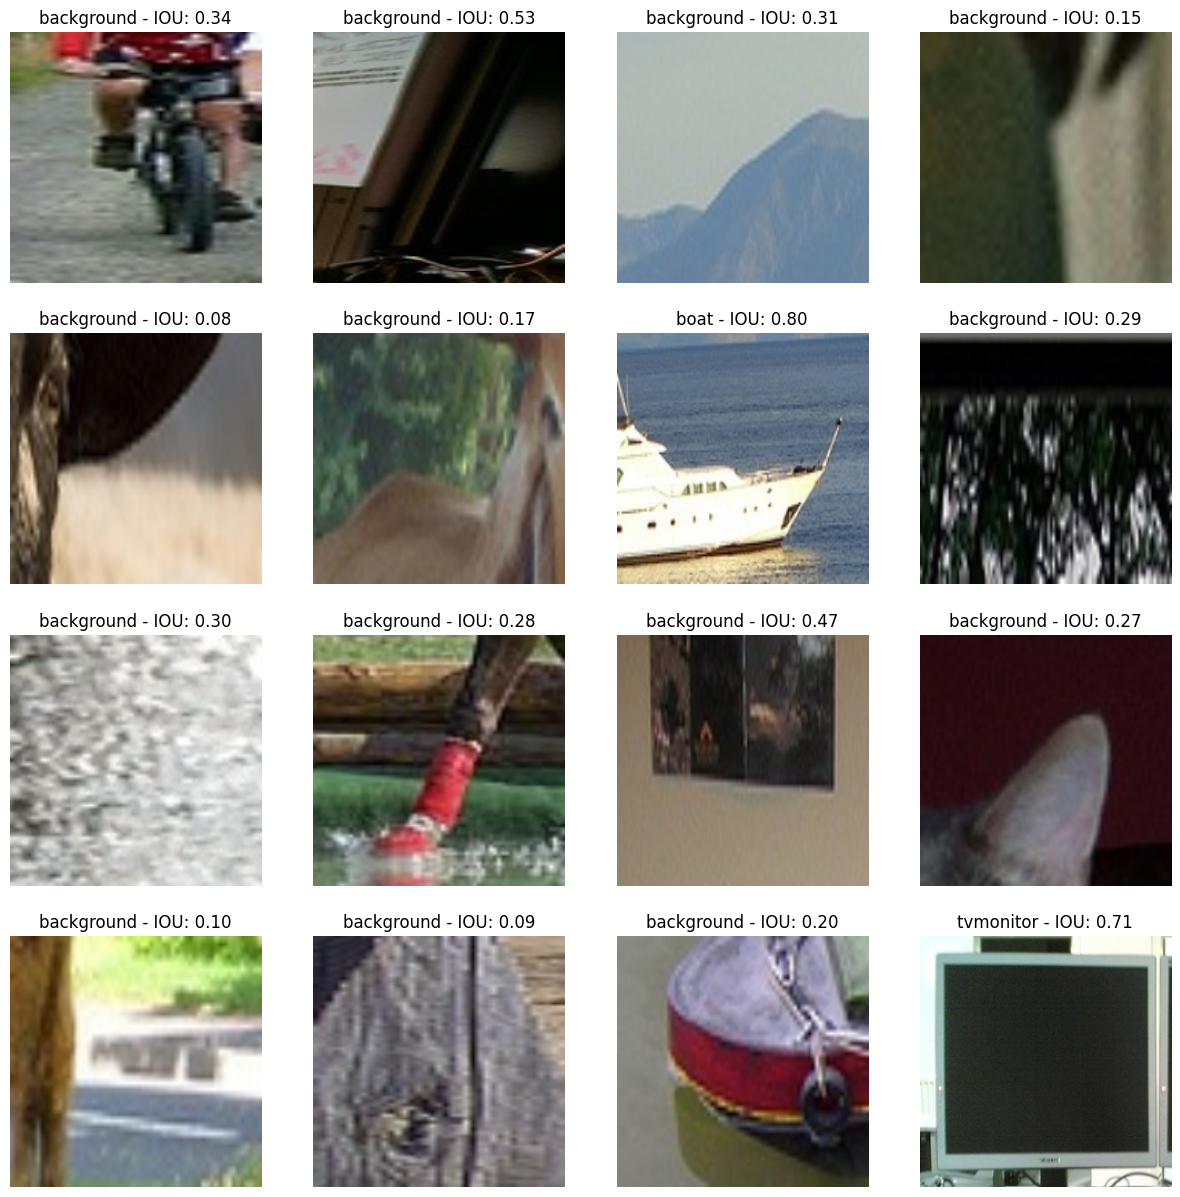

In [14]:
for batch in dataloader:
    images = batch["images"][:16]

    # get their labels
    labels = batch["labels"][:16]
    labels = [LABEL_NAMES[label] for label in labels]

    # compute iou between annotations and predictions
    annot_boxes = batch["annot_boxes"][:16]
    pred_boxes = batch["roi_boxes"][:16]
    ious = [calculate_iou(annot_box, pred_box) for annot_box, pred_box in zip(annot_boxes, pred_boxes)]

    # plot the images
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    for i, (image, label, iou) in enumerate(zip(images, labels, ious)):
        ax[i//4, i%4].imshow(image.permute(1, 2, 0))
        ax[i//4, i%4].set_title(f"{label} - IOU: {iou:.2f}")
        ax[i//4, i%4].axis("off")
    plt.show()
    break

## Model

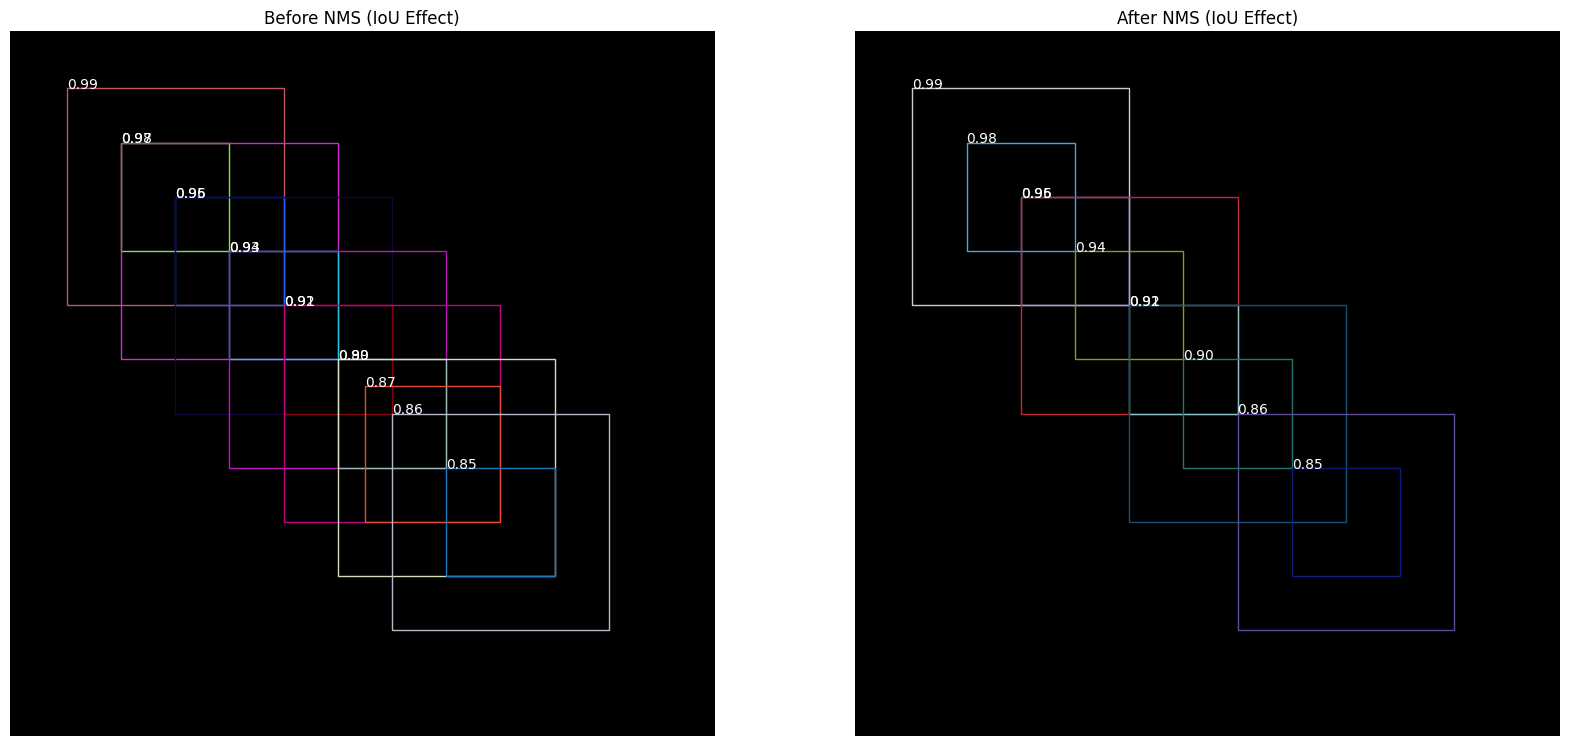

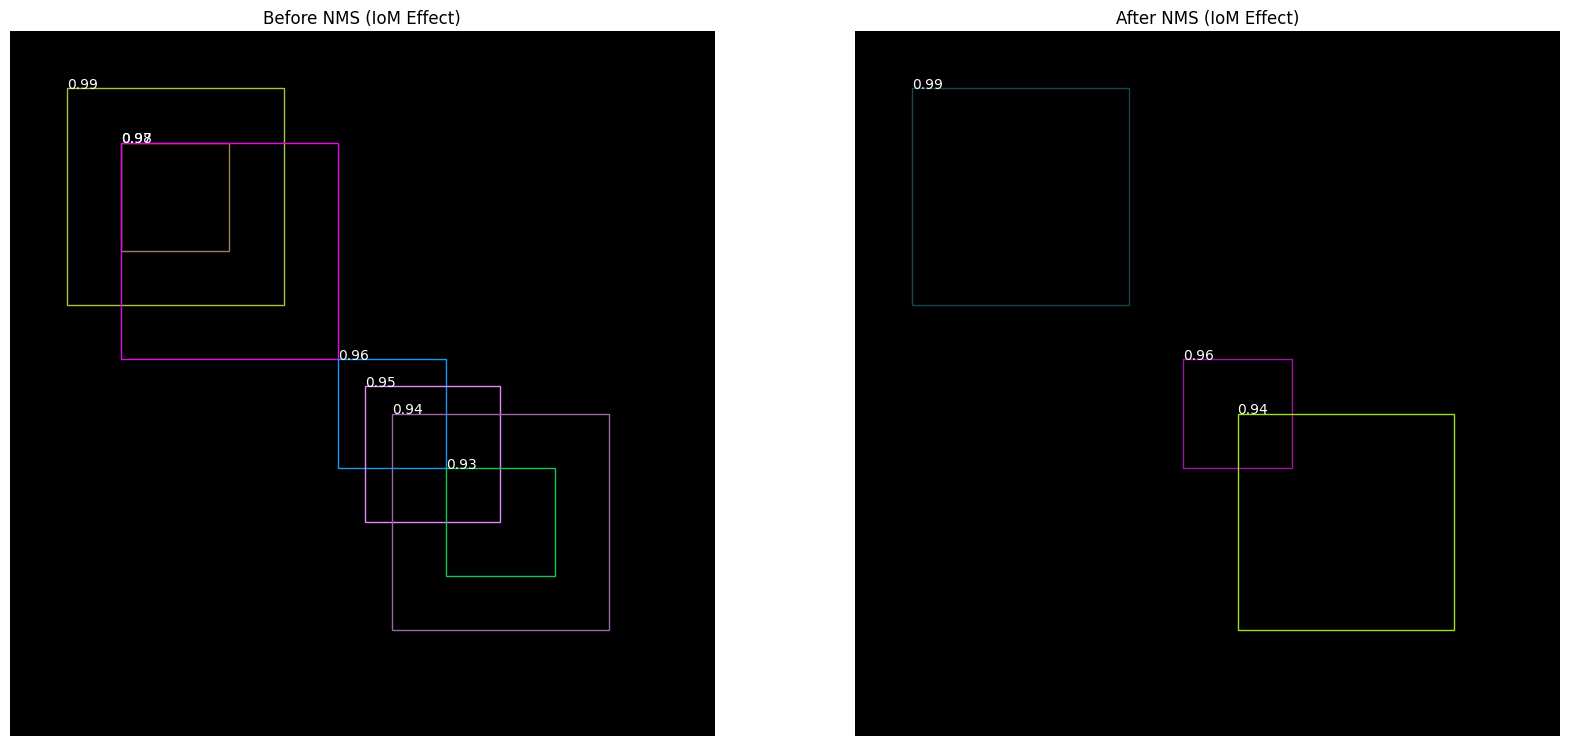

In [15]:
def non_max_suppression(boxes, scores, iou_threshold = 0.5, iom_threshold = 0.95, iou_iom = 0.2):
    if len(boxes) == 0:
        return []

    # Sort boxes by their scores in descending order
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    # Initialize list to keep track of selected boxes
    selected_indices = []

    while len(sorted_indices) > 0:
        # Select box with highest confidence score
        i = sorted_indices[0]
        selected_indices.append(i)

        # Calculate IoU with other boxes
        ious = [calculate_iou(boxes[i], boxes[j]) for j in sorted_indices[1:]]

        # Calculatge IoM with other boxes
        ioms = [calculate_iom(boxes[i], boxes[j]) for j in sorted_indices[1:]]

        # Filter out boxes with high IoU
        iou_filtered_indices = [j for j, iou in enumerate(ious) if iou <= iou_threshold]

        # Filter out boxes with high IoM
        iom_filtered_indices = [j for j in range(len(ioms)) if (ioms[j] <= iom_threshold or ious[j] <= iou_iom)]

        # Get intersection of filtered indices
        filtered_indices = set(iou_filtered_indices).intersection(set(iom_filtered_indices))

        # Remove indices of selected and filtered boxes
        sorted_indices = [sorted_indices[j + 1] for j in filtered_indices]

    return selected_indices

# Demo : Non Max Suppression
boxes = [
    [10, 10, 50, 50],
    [20, 20, 40, 40],
    [20, 20, 60, 60],
    [30, 30, 50, 50],
    [30, 30, 70, 70],
    [40, 40, 60, 60],
    [40, 40, 80, 80],
    [50, 50, 70, 70],
    [50, 50, 90, 90],
    [60, 60, 80, 80],
    [60, 60, 100, 100],
    [65, 65, 90, 90],
    [70, 70, 110, 110],
    [80, 80, 100, 100]
]

scores = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90, 0.89, 0.87, 0.86, 0.85]



fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(np.zeros((130, 130)), cmap='gray')
for i in range(len(boxes)):
    xmin, ymin, xmax, ymax = boxes[i]
    color = np.random.rand(3,)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=1)
    ax[0].add_patch(rect)
    ax[0].text(xmin, ymin, f"{scores[i]:.2f}", fontsize=10, color='white')
ax[0].axis('off')
ax[0].set_title("Before NMS (IoU Effect)")

# After NMS
selected_indices = non_max_suppression(boxes, scores, iou_threshold=0.3, iom_threshold=1)

ax[1].imshow(np.zeros((130, 130)), cmap='gray')
for i in selected_indices:
    xmin, ymin, xmax, ymax = boxes[i]
    color = np.random.rand(3,)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=1)
    ax[1].add_patch(rect)
    ax[1].text(xmin, ymin, f"{scores[i]:.2f}", fontsize=10, color='white')
ax[1].axis('off')
ax[1].set_title("After NMS (IoU Effect)")
plt.show()


boxes = [
    [10, 10, 50, 50],
    [20, 20, 40, 40],
    [20, 20, 60, 60],
    [60, 60, 80, 80],
    [65, 65, 90, 90],
    [70, 70, 110, 110],
    [80, 80, 100, 100]
]

scores = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93]


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(np.zeros((130, 130)), cmap='gray')
for i in range(len(boxes)):
    xmin, ymin, xmax, ymax = boxes[i]
    color = np.random.rand(3,)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=1)
    ax[0].add_patch(rect)
    ax[0].text(xmin, ymin, f"{scores[i]:.2f}", fontsize=10, color='white')
ax[0].axis('off')
ax[0].set_title("Before NMS (IoM Effect)")

# After NMS
selected_indices = non_max_suppression(boxes, scores, iou_threshold=1, iom_threshold=0.5)

# Plotting the second image
ax[1].imshow(np.zeros((130, 130)), cmap='gray')
for i in selected_indices:
    xmin, ymin, xmax, ymax = boxes[i]
    color = np.random.rand(3,)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=1)
    ax[1].add_patch(rect)
    ax[1].text(xmin, ymin, f"{scores[i]:.2f}", fontsize=10, color='white')
ax[1].axis('off')
ax[1].set_title("After NMS (IoM Effect)")
plt.show()

In [16]:
from torchvision.models import alexnet, AlexNet_Weights

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.alexnet = alexnet(weights=AlexNet_Weights.DEFAULT)
        self.convnet = nn.Sequential(*list(self.alexnet.features.children()))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(*list(self.alexnet.classifier.children())[:-1])

    def forward(self, x):
        x = self.convnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class RCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(4096, num_classes)
        self.bbox_regressor = nn.Linear(4096, 4)

    def refine_bbox(self, roi_box, transform_box):
        Px1, Py1, Px2, Py2 = roi_box
        Px, Py, Pw, Ph = (Px2 + Px1)/2, (Py1 + Py2)/2, Px2 - Px1, Py2 - Py1
        dPx, dPy, dPw, dPh = transform_box

        x = Px + Pw * dPx
        y = Py + Ph * dPy
        w = Pw * np.exp(dPw)
        h = Ph * np.exp(dPh)

        return x - w/2, y - h/2, x + w/2, y + h/2

    def forward(self, x):
        x = self.feature_extractor(x)
        return self.classifier(x), self.bbox_regressor(x)

    def inference(self, image, batch_size=128, box_reg = False, nms = False, transform=None, iou_threshold=0.5, iom_threshold=0.95, iou_iom=0.3):
        boxes = generate_region_proposals(image, MAX_PROPOSALS, fast_mode = False)

        # Save the RoIs and the dilated bounding boxes
        rois = []
        for i, bbox in enumerate(boxes):
            roi, bbox = dilate(image, bbox)
            if transform:
                roi = transform(roi)
            rois.append(roi)
            boxes[i] = bbox

        # Stack the RoIs into a single tensor
        rois = torch.stack(rois)

        # Initialize lists to store labels, boxes and scores
        labels = []
        scores = []
        for i in range(0, len(rois), batch_size):
            batch = rois[i:i+batch_size]
            batch = batch.to(DEVICE)
            with torch.no_grad():
                out_classes, out_boxes = self.forward(batch)

            labels.extend(torch.argmax(out_classes, dim=1).cpu().tolist())
            scores.extend(torch.max(torch.softmax(out_boxes, dim=1), dim=1).values.cpu().tolist())

        # Discard background boxes
        indices = [i for i, label in enumerate(labels) if label != 0]
        labels = [labels[i] for i in indices]
        scores = [scores[i] for i in indices]
        boxes = [boxes[i] for i in indices]

        # Apply Non-Maximum Suppression
        if nms:
            selected_indices = non_max_suppression(boxes, scores, iou_threshold, iom_threshold, iou_iom)
            labels = [labels[i] for i in selected_indices]
            scores = [scores[i] for i in selected_indices]
            boxes = [boxes[i] for i in selected_indices]

        return {"labels" : labels, "scores": scores, "boxes" : boxes}


## Training Loop

In [17]:
from torch.optim.lr_scheduler import StepLR

def finetune(model, data_loader, num_epochs = EPOCHS):
    """
    Fine-tunes the given model.

    Parameters:
        model (nn.Module): The model to be fine-tuned.
        data_loader (DataLoader): The DataLoader providing the training data.
        num_epochs (int, optional): The number of training epochs. Defaults to the value of EPOCHS.

    Returns:
        nn.Module: The fine-tuned model.
    """
    criterion = nn.CrossEntropyLoss()
    for param in model.feature_extractor.parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True
    for param in model.bbox_regressor.parameters():
        param.requires_grad = False

    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        running_cls_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for step, data in enumerate(data_loader):
            images = data['images'].to(DEVICE)
            labels = data['labels'].to(DEVICE)

            optimizer.zero_grad()
            cls_pred, _ = model(images)


            loss = criterion(cls_pred, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_cls_loss += loss.item()
            _, predicted = torch.max(cls_pred.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            if step % 20 == 19:
                print(f"Step {step+1}/{len(data_loader)} completed - loss {loss} - accuracy {100 * correct_predictions / total_samples:.2f}%")

        # Update learning rate (/10)
        scheduler.step()

        # Calculate and print epoch statistics
        epoch_cls_loss = running_cls_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Classification Loss: {epoch_cls_loss:.4f}, "
              f"Accuracy: {100 * epoch_accuracy:.2f}%")


    return model

In [18]:
# Fine tuning the feature extractor and the classifier
model = RCNN(num_classes=N_CLASSES).to(DEVICE)
model = finetune(model, dataloader, EPOCHS)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 452MB/s]


Epoch 1/2
Step 20/316 completed - loss 1.0678077936172485 - accuracy 69.84%
Step 40/316 completed - loss 1.0934966802597046 - accuracy 73.34%
Step 60/316 completed - loss 0.8976379036903381 - accuracy 75.55%
Step 80/316 completed - loss 1.1422772407531738 - accuracy 76.86%
Step 100/316 completed - loss 0.6983132362365723 - accuracy 78.48%
Step 120/316 completed - loss 0.5118371844291687 - accuracy 79.51%
Step 140/316 completed - loss 0.641240119934082 - accuracy 80.27%
Step 160/316 completed - loss 0.8233312368392944 - accuracy 80.78%
Step 180/316 completed - loss 0.58881676197052 - accuracy 81.21%
Step 200/316 completed - loss 0.888346254825592 - accuracy 81.55%
Step 220/316 completed - loss 0.46299123764038086 - accuracy 81.92%
Step 240/316 completed - loss 0.6339447498321533 - accuracy 82.19%
Step 260/316 completed - loss 0.9261007308959961 - accuracy 82.38%
Step 280/316 completed - loss 0.6493500471115112 - accuracy 82.30%
Step 300/316 completed - loss 0.5155120491981506 - accuracy

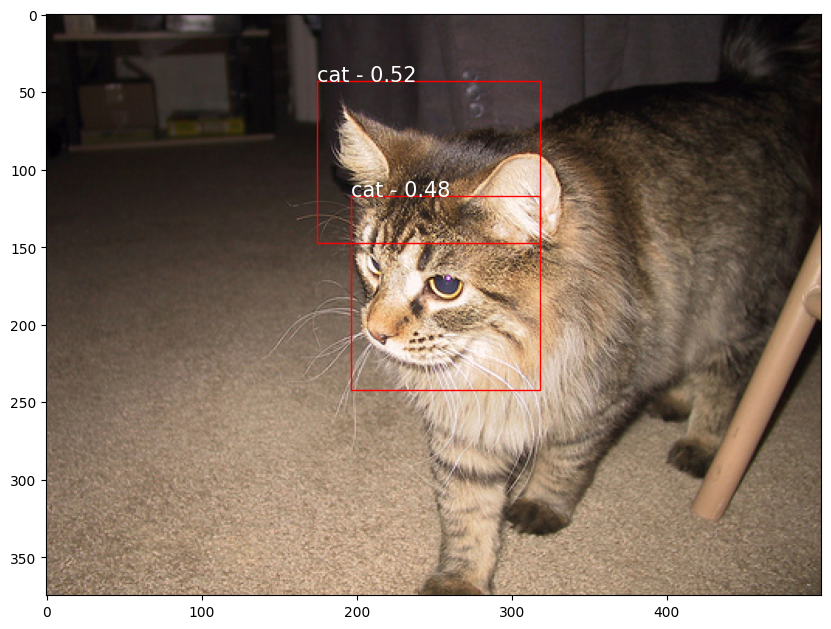

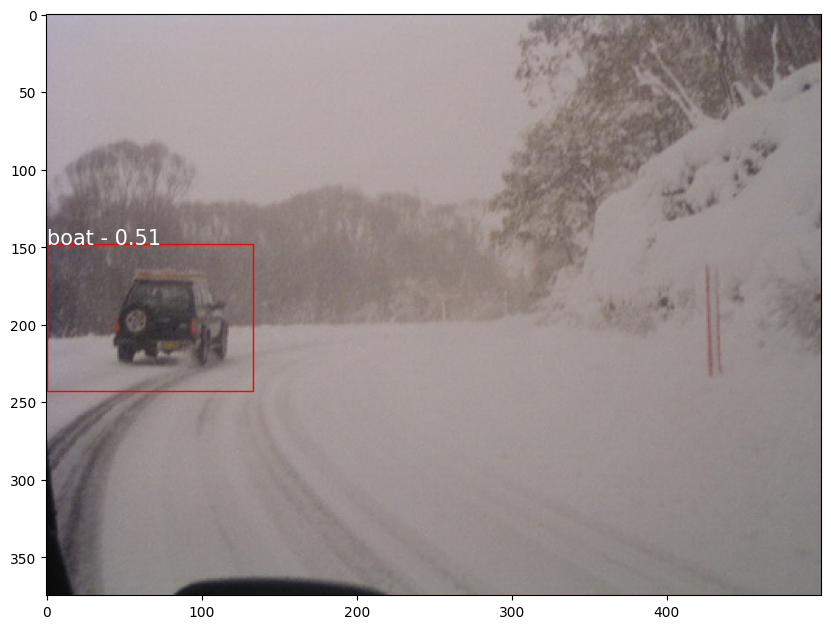

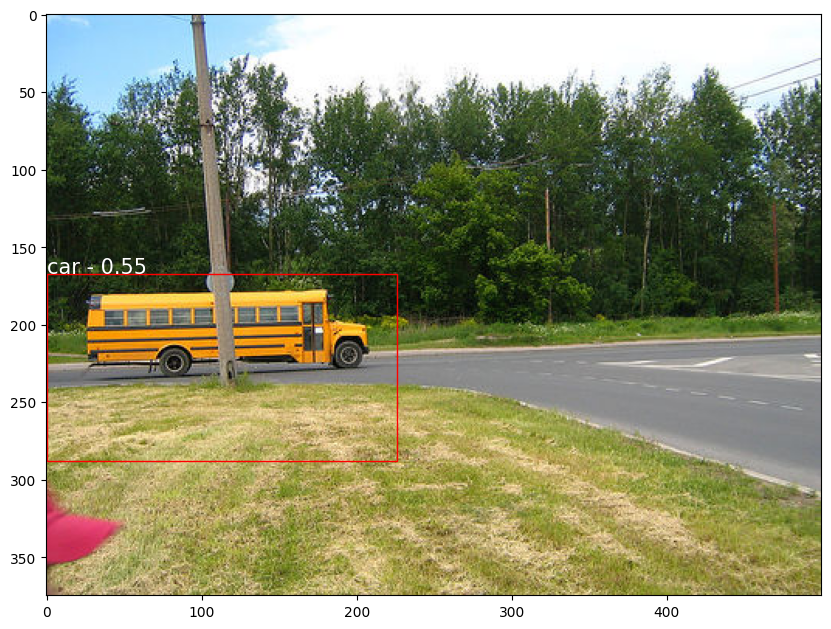

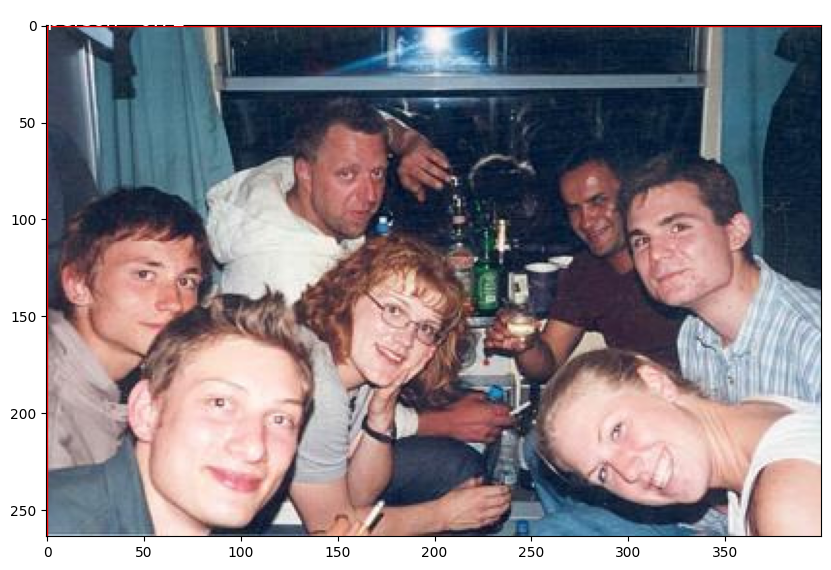

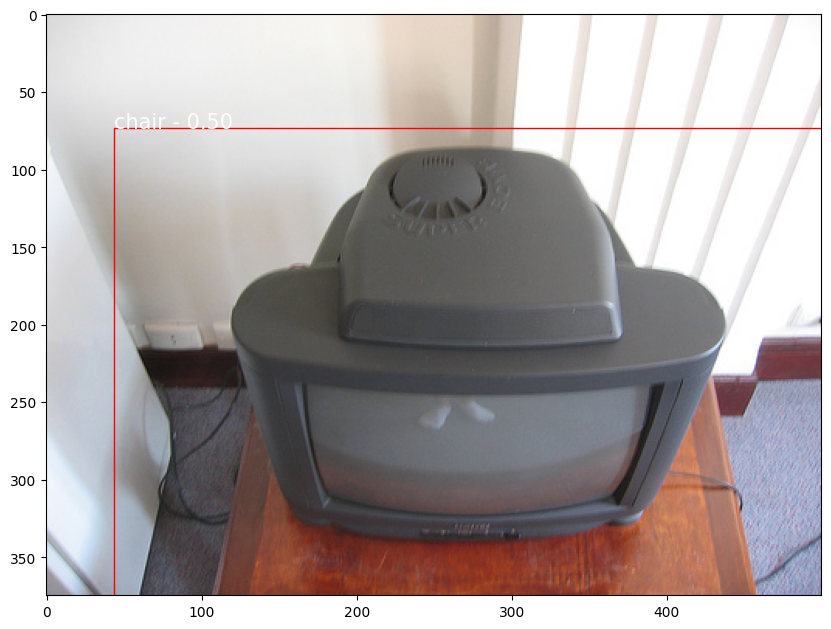

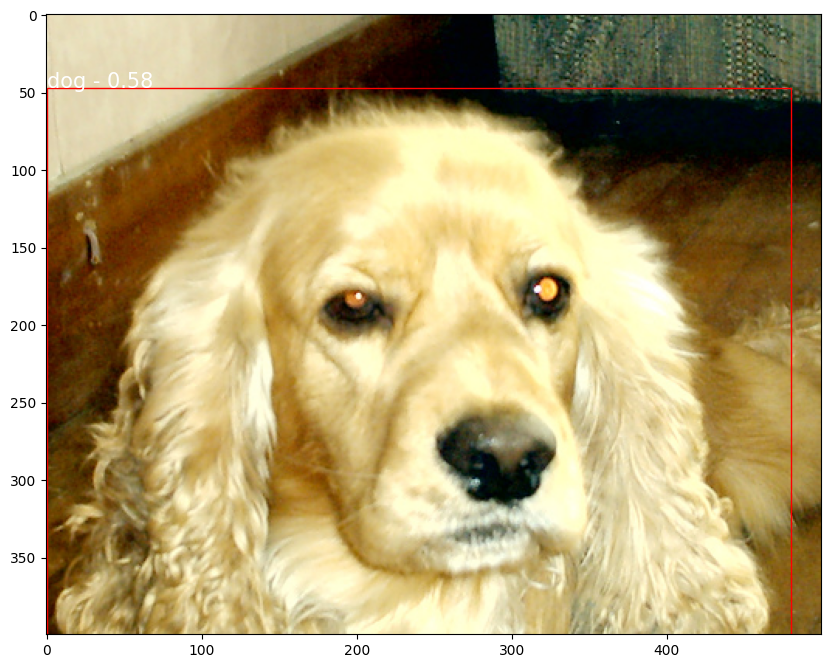

In [19]:
detections = []

for image_name in TEST_IMAGE_NAMES[:6]:
    image_annotations = load_image_annotations(image_name)
    image_path = os.path.join(TEST_IMAGES_PATH, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection = model.inference(image, transform=transform, nms = True, iou_threshold=0.45, iom_threshold=0.4, iou_iom=0)

    detections.append(detection)

    # visualize the image and the detections on it
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    for label, score, box in zip(detection["labels"], detection["scores"], detection["boxes"]):
        if score > 0.4:
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, fill=False, color="red")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{LABEL_NAMES[label]} - {score:.2f}", color="white", fontsize=15)
    plt.show()